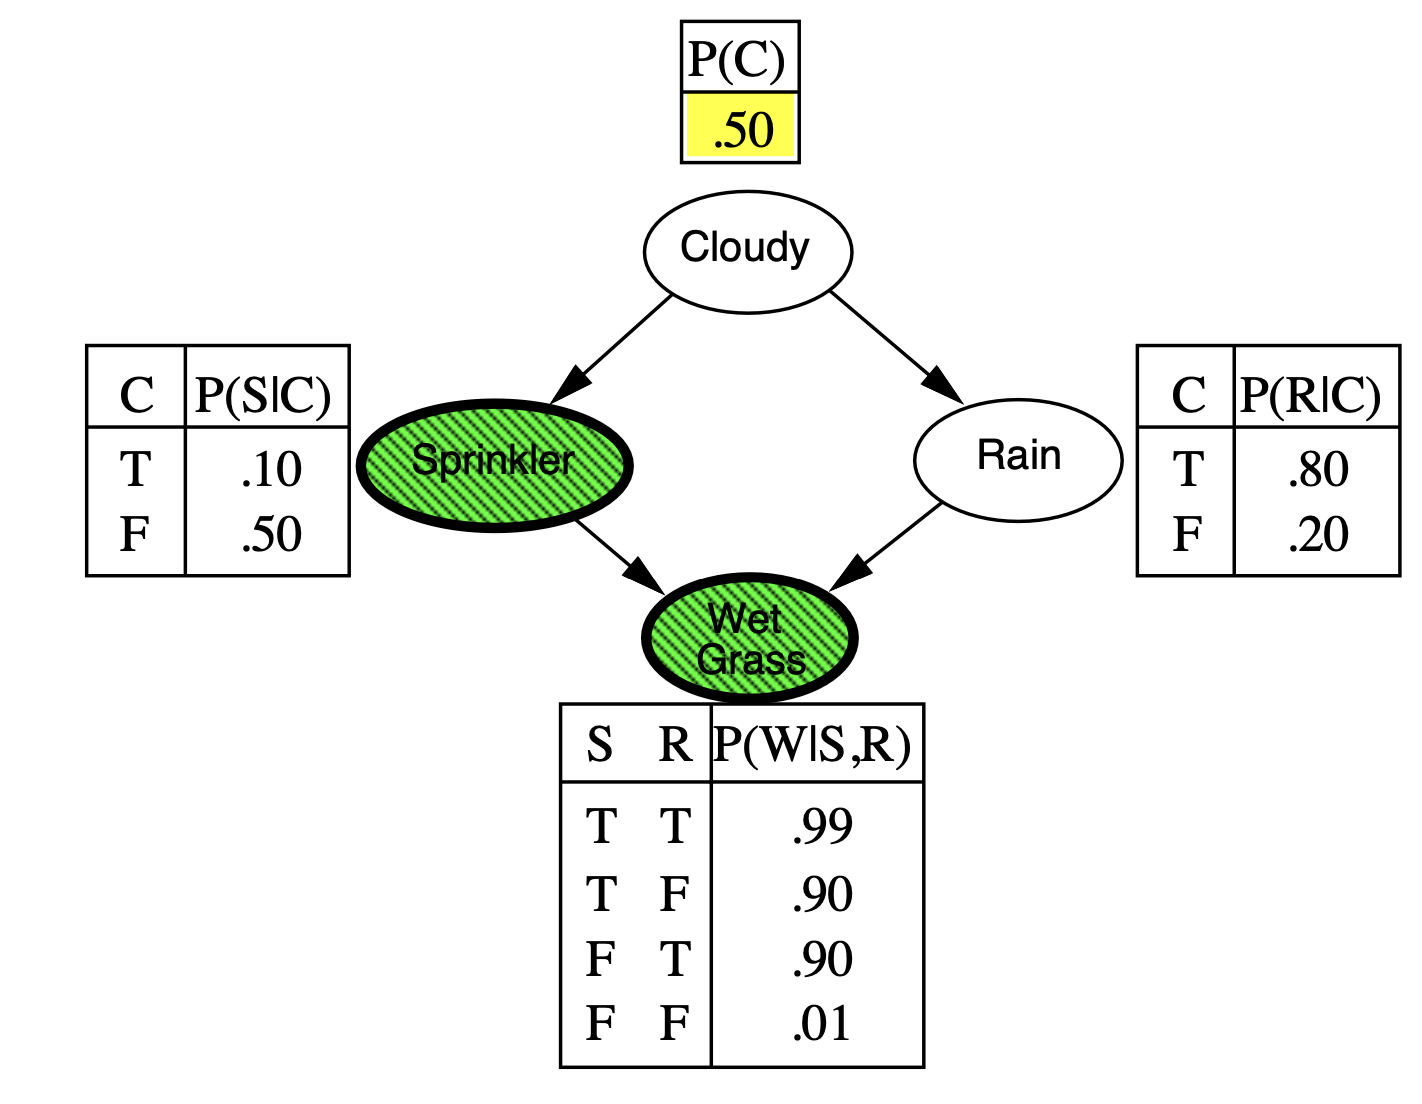

# Find P(r | s, w)
By enumeration, we know that this value is P(r | s, w) $\approx$ .320

## Setup probability tables

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Our cpt tables only store the values when the variable of interest is true
# In the problems that follow, we need to take 1 - P(X_i = T | Parents(X_i)) in order to find the 
# probability of our variable of interest being false
# As an example, to find P(¬c) we take 1 - c_cpt
c_cpt = .5
s_cpt = np.array([.5, .1])
r_cpt = np.array([.2, .8])
w_cpt = np.array([[.01, .9], [.9, .99]])

## Rejection Sampling

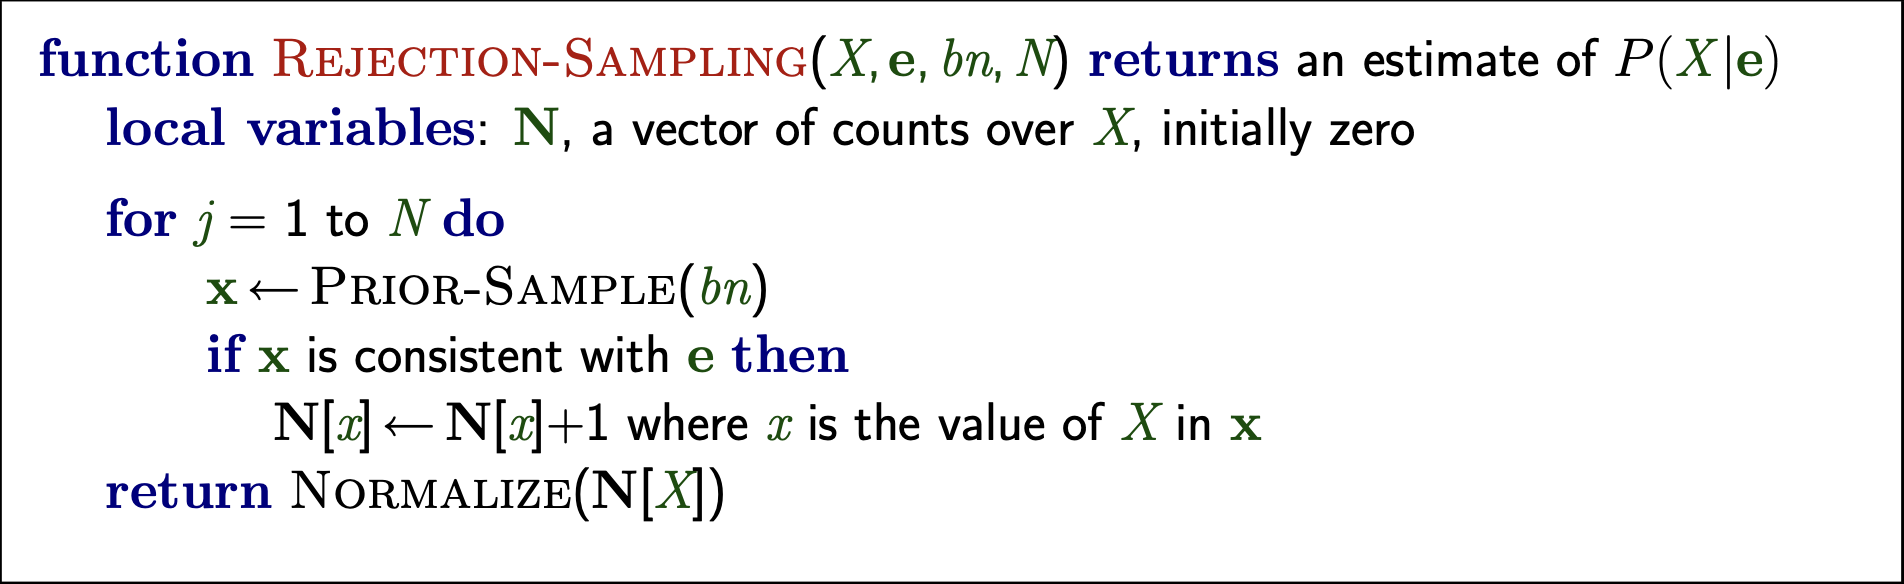

In [3]:
N = 100000
rej_samples = []
for _ in range(N):
    c = int(random.uniform(0, 1) < c_cpt)
    s = int(random.uniform(0, 1) < s_cpt[c])
    r = int(random.uniform(0, 1) < r_cpt[c])
    w = int(random.uniform(0, 1) < w_cpt[s, r])
    
    rej_samples.append([c, s, r, w])
    
rej_prob = []
running_length = 0
running_r = 0
cur_prob = 0.0
for sample in rej_samples:
    if sample[1] and sample[3]:
        running_length += 1
        running_r += sample[2]
        cur_prob = running_r / running_length
        
    rej_prob.append(cur_prob)

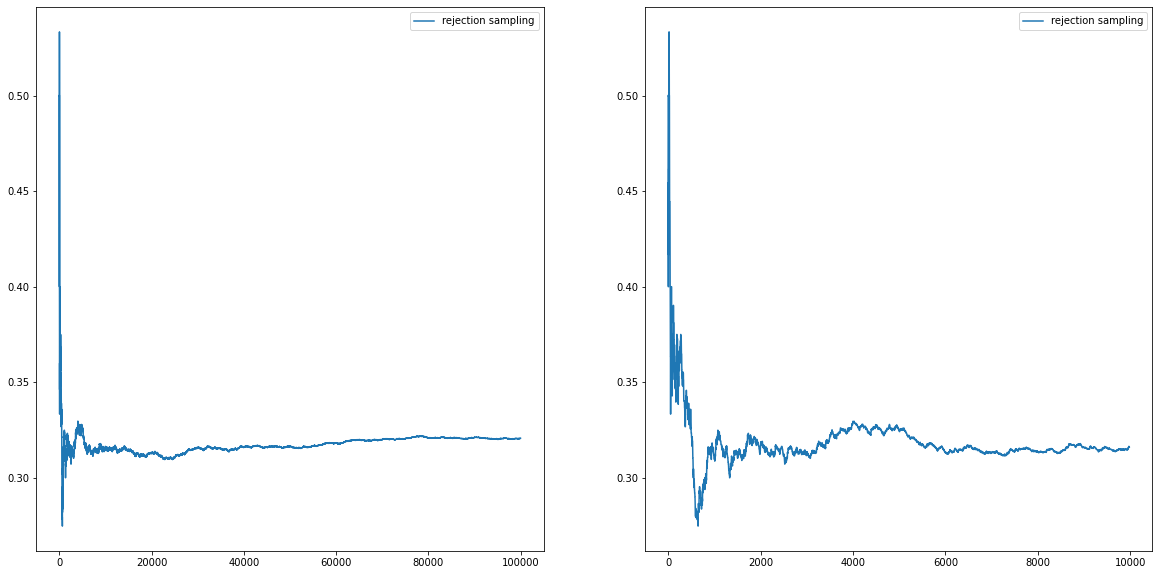

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(rej_prob[20:], label='rejection sampling')
ax[0].legend()

ax[1].plot(rej_prob[20:10000], label='rejection sampling')
ax[1].legend()

# Likelihood weighting

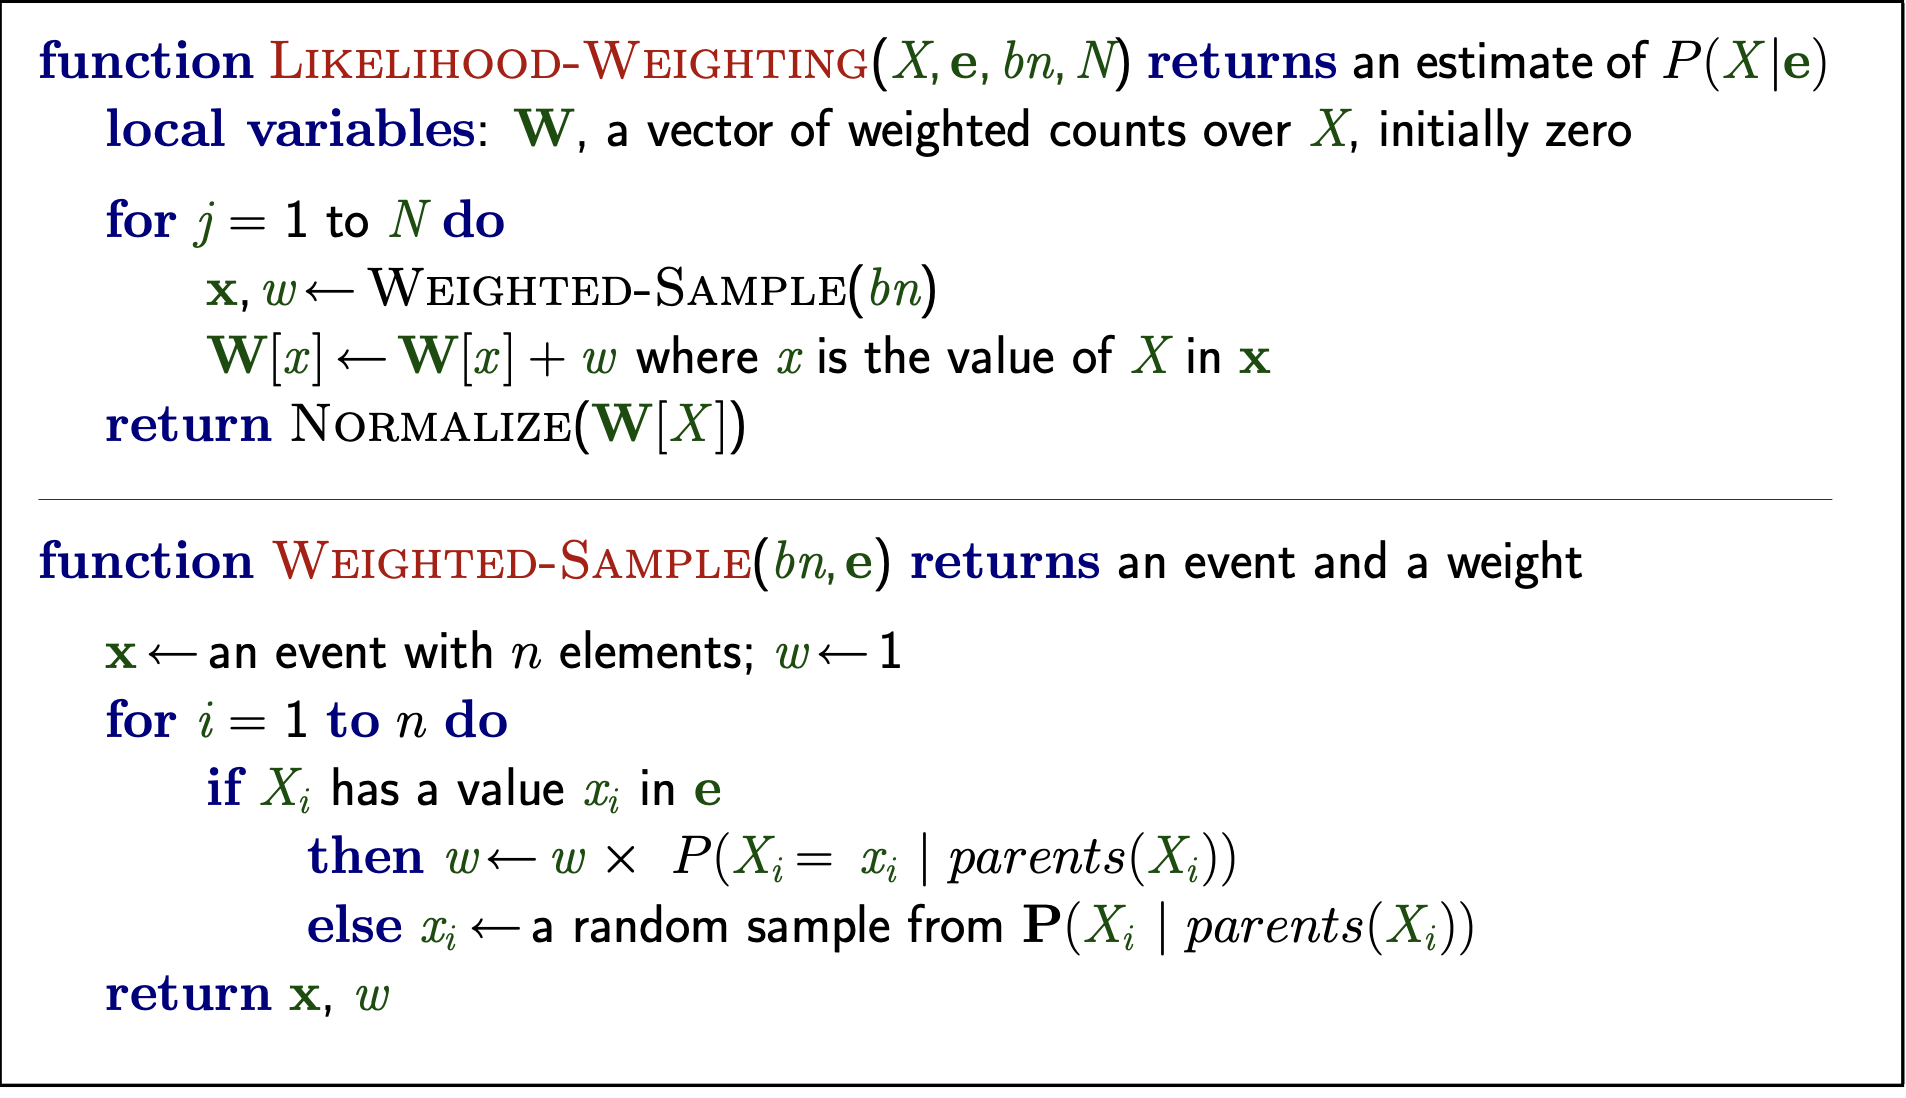

In [5]:
like_samples = []
like_weights = []

s = 1
w = 1

def normalize(weights):
    return weights[1] / sum(weights)

for _ in range(N):
    c = int(random.uniform(0, 1) < c_cpt)
    r = int(random.uniform(0, 1) < r_cpt[c])
    
    weight = 1.0
    weight *= s_cpt[c] if s else 1 - s_cpt[c]
    weight *= w_cpt[s, r] if w else 1 - w_cpt[s, r]
    
    like_samples.append(r)
    like_weights.append(weight)

like_prob = []
like_normal = [0.0, 0.0]

for i in range(len(like_samples)):
    cur_sample = like_samples[i]
    cur_weight = like_weights[i]
    like_normal[cur_sample] += cur_weight
    
    like_prob.append(normalize(like_normal))

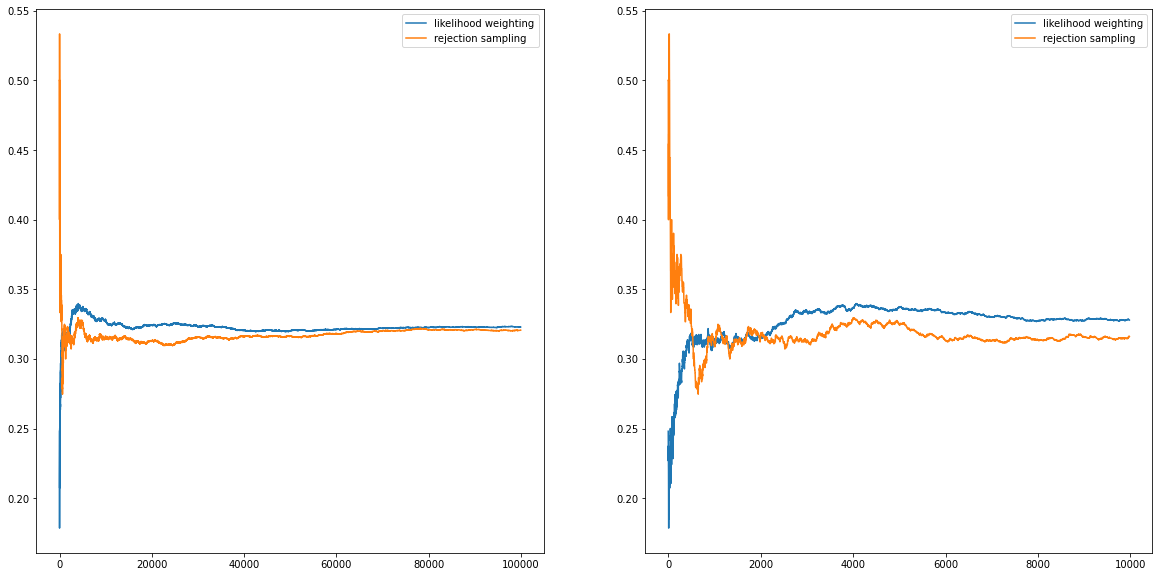

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(like_prob[20:], label='likelihood weighting')
ax[0].plot(rej_prob[20:], label='rejection sampling')
ax[0].legend()

ax[1].plot(like_prob[20:10000], label='likelihood weighting')
ax[1].plot(rej_prob[20:10000], label='rejection sampling')
ax[1].legend()

# Gibbs Sampling

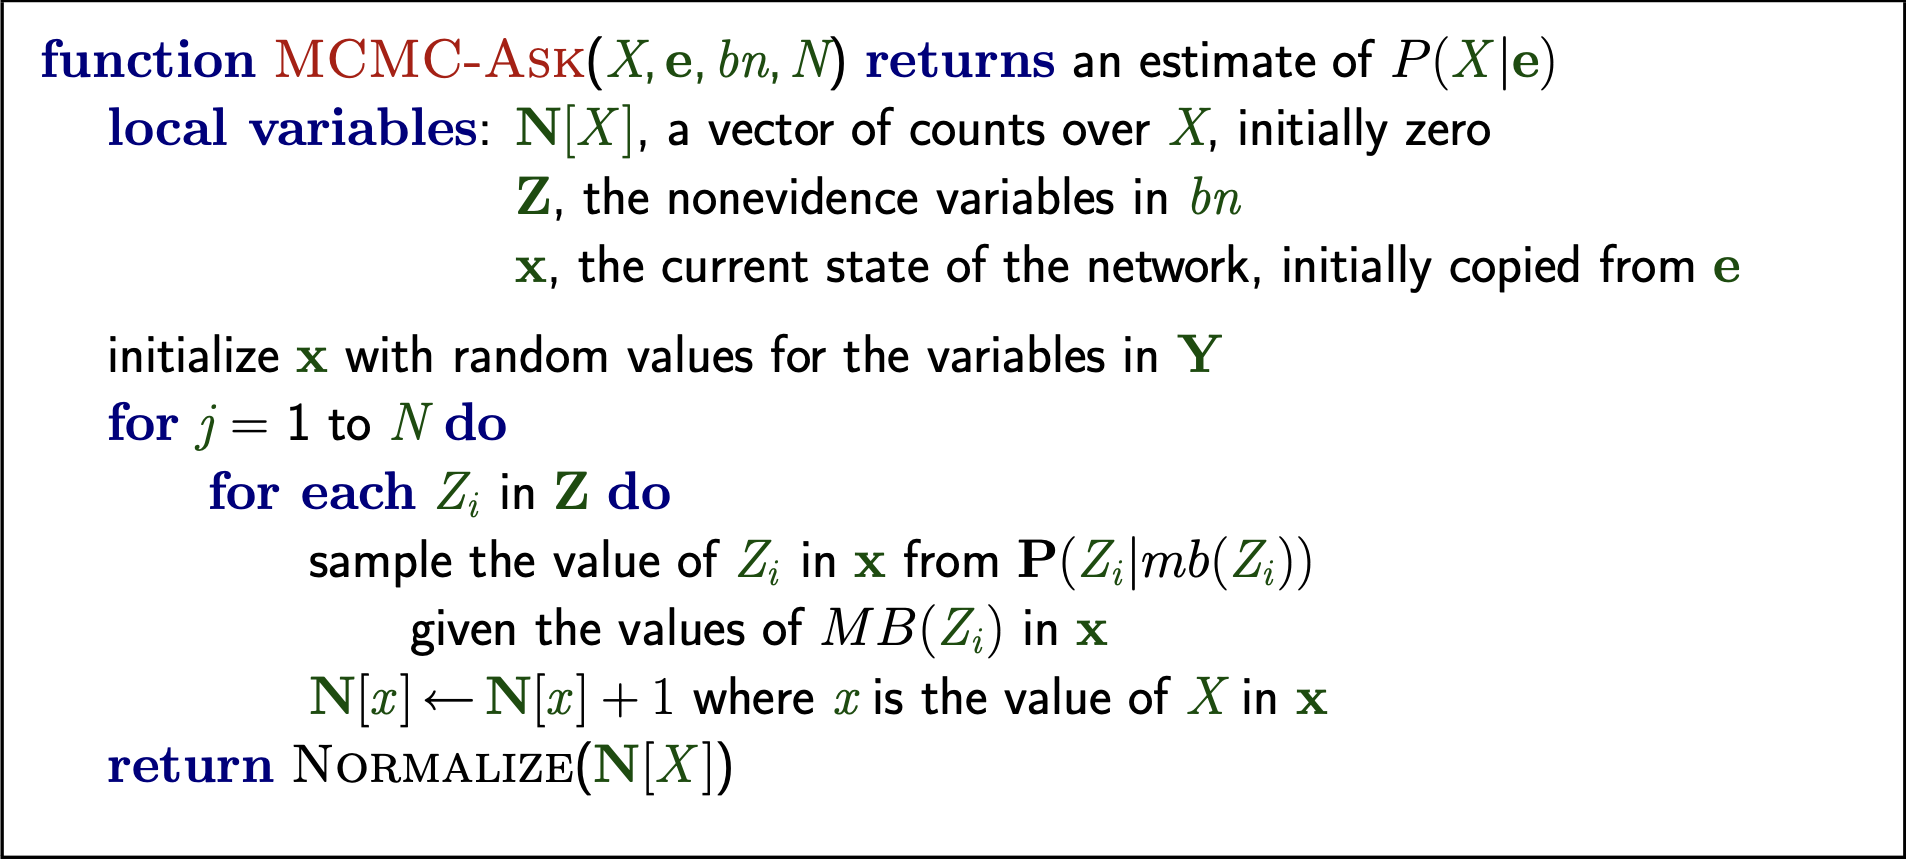

In general, to compute $P(Z_i | mb(Z_i))$, we have

&nbsp;

$$
\begin{aligned}
P(Z_i | mb(Z_i)) = \alpha \hspace{5pt} \times \hspace{2pt} P(Z_i |Parents(Z_i)) \hspace{5pt} \times \hspace{5pt} \prod_{Y \in Children(Z_i)} P(Y | Parents(Y))
\end{aligned}
$$

&nbsp;

Given that we are only sampling from our non-evidence variables, we only need to sample from R and C. 

In order to sample from these two variables we must compute P(R | mb(R)) and P(C | mb(C)), respectively. Let's consider these in turn.

&nbsp;


Starting with P(C | mb(C))
$$
\begin{aligned}
P(C | mb(C)) = \alpha \hspace{5pt} \times \hspace{2pt} P(C) \hspace{5pt} \times \hspace{5pt} P(s | C) \hspace{5pt} \times \hspace{5pt} P(R = r_j| C)
\end{aligned}
$$

&nbsp;

&nbsp;

Turning to P(R | mb(R))
$$
\begin{aligned}
P(R | mb(R)) = \alpha \hspace{5pt} \times \hspace{2pt} P(R| C = c_j) \hspace{5pt} \times \hspace{5pt} P(w | s, R)
\end{aligned}
$$

&nbsp;

Note that in both of the above terms, c_j and r_j represent the sample values of C and R, respectively, for the j-th iteration of our outer for loop.

## Precomputed Gibbs Sampling
This implementation computes the probabilities P(Z_i | mb(Z_i)) for all possible combinations of Z_i and its markov blanket Z_i before entering the for loop so that we have simple lookup tables in our for loop.

In [7]:
# Our evidence variables are not sampled, we hard-code them here
s = 1
w = 1



# Compute the probability P(C = T | mb(C)) for all possible values of mb(C)
# Original hard-coded value of c_transitions = [1/21, 4/9]

c_transitions_full = np.zeros((2, 2))
for c in [0, 1]:
    for r in [0, 1]:
        p_c = c_cpt if c else 1 - c_cpt
        p_r = r_cpt[c] if r else 1 - r_cpt[c]
        p_s = s_cpt[c] if s else 1 - s_cpt[c]
        c_transitions_full[c, r] = p_c * p_r * p_s
    
alphas = np.sum(c_transitions_full, axis = 0)
c_transitions = c_transitions_full[1] / alphas
    
    


# Compute the probability P(R = T | mb(R)) for all possible values of mb(R)
# Original hard-coded value of r_transitions = [11/51, 22/27]

r_transitions_full = np.zeros((2, 2))
for r in [0, 1]:
    for c in [0, 1]:
        p_r = r_cpt[c] if r else 1 - r_cpt[c]
        p_w = w_cpt[s, r] if w else 1 - w_cpt[s, r]
        r_transitions_full[r, c] = p_r * p_w
    
alphas = np.sum(r_transitions_full, axis = 0)
r_transitions = r_transitions_full[1] / alphas

In [8]:
cur_c = 1
cur_r = 1
states = [[cur_c, cur_r]]

for _ in range(int(N/2)):
    _, cur_r = states[-1]
    # First sample the c variable
    cur_c = int(random.uniform(0, 1) < c_transitions[cur_r])
    states.append([cur_c, cur_r])
    
    # Then sample the r variable
    cur_r = int(random.uniform(0, 1) < r_transitions[cur_c])
    states.append([cur_c, cur_r])
    
gibbs_probs = []
running_r = 0
for idx, sample in enumerate(states):
    running_r += sample[1]
    gibbs_probs.append(running_r/(idx+1))

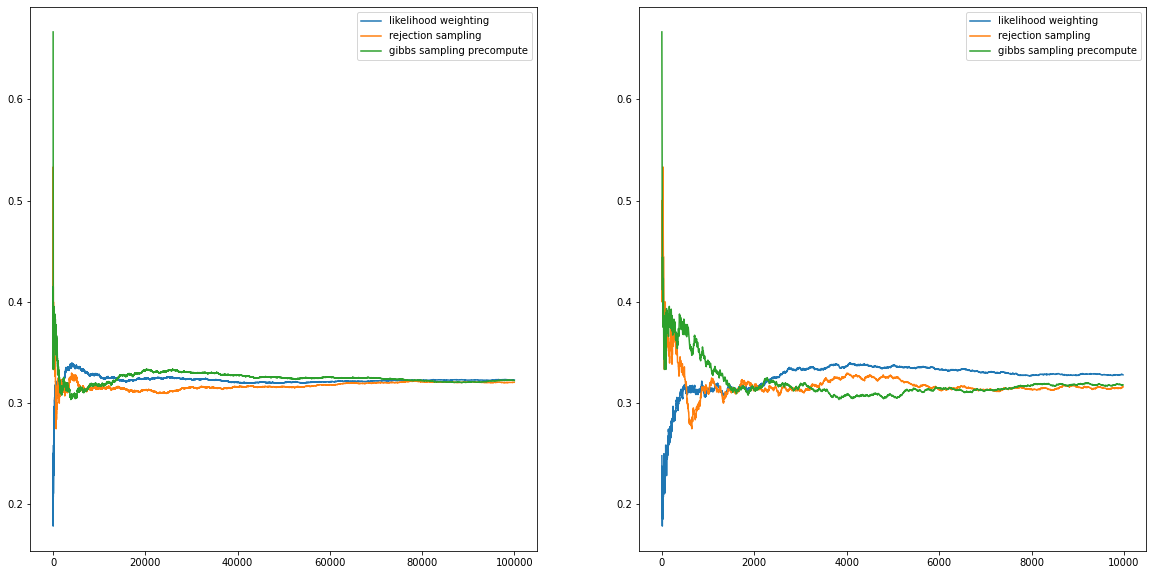

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(like_prob[20:], label='likelihood weighting')
ax[0].plot(rej_prob[20:], label='rejection sampling')
ax[0].plot(gibbs_probs[20:], label='gibbs sampling precompute')
ax[0].legend()

ax[1].plot(like_prob[20:10000], label='likelihood weighting')
ax[1].plot(rej_prob[20:10000], label='rejection sampling')
ax[1].plot(gibbs_probs[20:10000], label='gibbs sampling precompute')
ax[1].legend()

## Online Gibbs Sampling
Here, we compute the probability P(Z_i | mb(Z_i)) inside of our for loop

In [10]:
# Our evidence variables are not sampled, we hard-code them here
s = 1
w = 1


cur_c = 1
cur_r = 1
states = [[cur_c, cur_r]]


for _ in range(int(N/2)):
    # Calculate P(C | mb(C))
    p_c_mb = np.zeros(2)
    for c in [0, 1]:
        p_c = c_cpt if c else 1 - c_cpt
        p_r = r_cpt[c] if cur_r else 1 - r_cpt[c]
        p_s = s_cpt[c] if s else 1 - s_cpt[c]
        p_c_mb[c] = p_c * p_r * p_s
    p_c_mb /= np.sum(p_c_mb)
    
    
    # Sample C variable
    cur_c = int(random.uniform(0, 1) < p_c_mb[1])
    states.append([cur_c, cur_r])
    
    # Calculate P(R | mb(R))
    p_r_mb = np.zeros(2)
    for r in [0, 1]:
        p_r = r_cpt[cur_c] if r else 1 - r_cpt[cur_c]
        p_w = w_cpt[s, r] if w else 1 - w_cpt[s, r]
        p_r_mb[r] = p_r * p_w
    p_r_mb /= np.sum(p_r_mb)
    
    # Sample R variable
    cur_r = int(random.uniform(0, 1) < p_r_mb[1])
    states.append([cur_c, cur_r])
    
gibbs_probs_alt = []
running_r = 0
for idx, sample in enumerate(states):
    running_r += sample[1]
    gibbs_probs_alt.append(running_r/(idx+1))

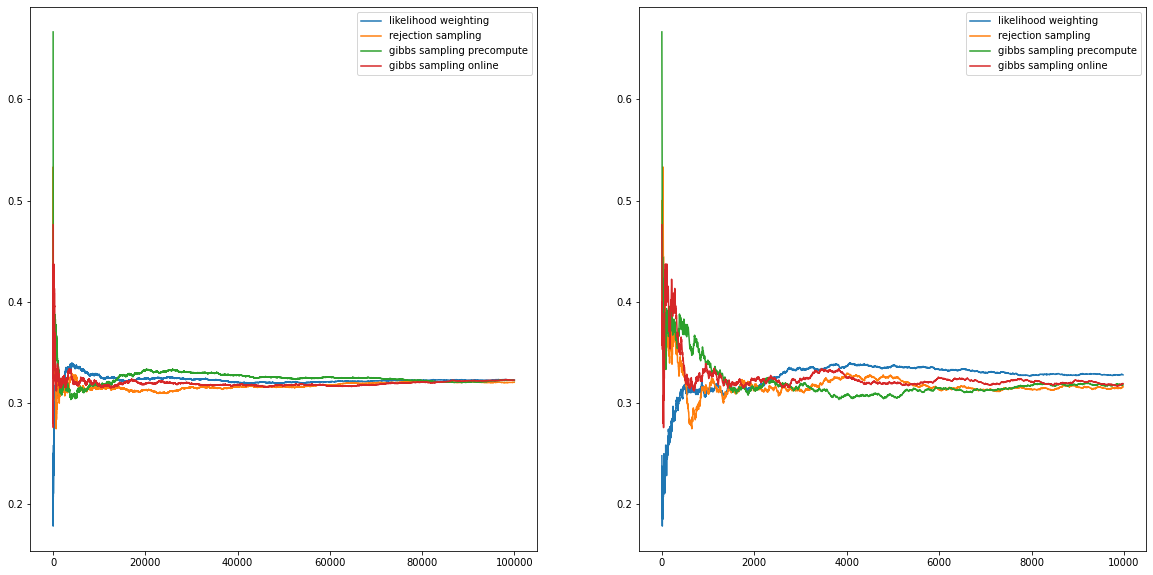

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(like_prob[20:], label='likelihood weighting')
ax[0].plot(rej_prob[20:], label='rejection sampling')
ax[0].plot(gibbs_probs[20:], label='gibbs sampling precompute')
ax[0].plot(gibbs_probs_alt[20:], label='gibbs sampling online')
ax[0].legend()

ax[1].plot(like_prob[20:10000], label='likelihood weighting')
ax[1].plot(rej_prob[20:10000], label='rejection sampling')
ax[1].plot(gibbs_probs[20:10000], label='gibbs sampling precompute')
ax[1].plot(gibbs_probs_alt[20:10000], label='gibbs sampling online')
ax[1].legend()

## Using Markov Transition matrix
Here we use our Q matrix directly to compute P(r | s, w)

In [12]:
transition_matrix = np.array([
    [.629, .093, .278, 0],
    [.408, .116, 0, .476],
    [.222, 0, .386, .392],
    [0, .024, .108, .868]
])

probs = np.array([.25, .25, .25, .25])

matrix_probs = []
for _ in range(N):
    probs = np.dot(probs, transition_matrix)
    matrix_probs.append(probs[0] + probs[2])

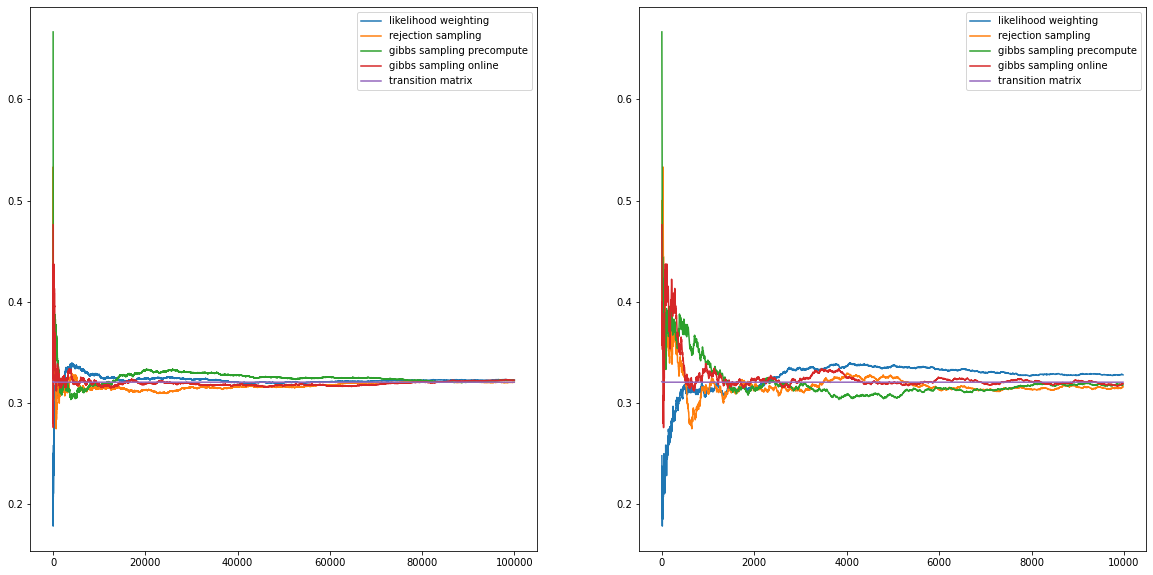

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(like_prob[20:], label='likelihood weighting')
ax[0].plot(rej_prob[20:], label='rejection sampling')
ax[0].plot(gibbs_probs[20:], label='gibbs sampling precompute')
ax[0].plot(gibbs_probs_alt[20:], label='gibbs sampling online')
ax[0].plot(matrix_probs[20:], label='transition matrix')
ax[0].legend()

ax[1].plot(like_prob[20:10000], label='likelihood weighting')
ax[1].plot(rej_prob[20:10000], label='rejection sampling')
ax[1].plot(gibbs_probs[20:10000], label='gibbs sampling precompute')
ax[1].plot(gibbs_probs_alt[20:10000], label='gibbs sampling online')
ax[1].plot(matrix_probs[20:10000], label='transition matrix')
ax[1].legend()

Text(0.5, 1.0, 'Matrix Multiplication with Q')

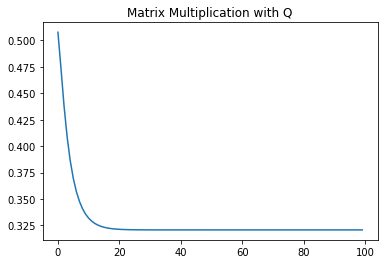

In [14]:
plt.plot(matrix_probs[:100])
plt.title('Matrix Multiplication with Q')